In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import copy
import cv2
from PIL import Image
import os
import seaborn as sns
import random as rand
import math
import umap
from mpl_toolkits.mplot3d import Axes3D

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
#set seeds to ensure reproducibility of results
SEED = 1
# Python built-in random
rand.seed(SEED)
# NumPy
np.random.seed(SEED)
# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [4]:
class Dataset(torchvision.datasets.CIFAR10):
  def __init__(self, path, image_dims = (32, 32), n_channels = 3, train = True):
    super().__init__(path, train, download = True)
    self.n_classes = 10
    self.image_dims = image_dims
    self.n_channels = n_channels
    self.resize = transforms.Resize(image_dims)
    self.to_tensor = transforms.ToTensor()

  def __getitem__(self, index):
    image, label = super().__getitem__(index)

    Y_output = self.resize(image)
    X_input, X_mask = self.Create_Mask(Y_output)
    return self.to_tensor(X_input), self.to_tensor(X_mask), self.to_tensor(Y_output), label

  def Create_Mask(self, image):
    mask = np.full((self.image_dims[0], self.image_dims[1], self.n_channels), 255, dtype = np.uint8)

    for _ in range(np.random.randint(1, 10)):
      x1, x2 = np.random.randint(1, self.image_dims[0]), np.random.randint(1, self.image_dims[0])
      y1, y2 = np.random.randint(1, self.image_dims[1]), np.random.randint(1, self.image_dims[1])
      thickness = np.random.randint(1, 3)

      cv2.line(mask, (x1, y1), (x2, y2), (1, 1, 1), thickness)

    image = np.asarray(image)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image, mask

In [5]:
Trainset = Dataset('./data')
Testset = Dataset('./data', train=False)

## EDA

In [6]:
# Get the list of class names
class_names = Trainset.classes

# Print the mapping from numerical labels to string labels
for idx, class_name in enumerate(class_names):
    print(f"{idx}: {class_name}")

idx_to_class = {idx: class_name for idx, class_name in enumerate(class_names)}

0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck


In [7]:
train_labels_list = [idx_to_class[item] for item in Trainset.targets]
val_labels_list = [idx_to_class[item] for item in Testset.targets]

In [8]:
def show_imgs(masked_image, mask, original_image, label, title1 = "Masked Image", title2 = "Mask", title3 = "Original Image"):
  f, axs = plt.subplots(1,3)
  axs[0].imshow(np.transpose(masked_image.numpy(), (1,2,0)))
  axs[0].set_title(title1)
  axs[1].imshow(np.transpose(mask.numpy(), (1,2,0)))
  axs[1].set_title(title2)
  axs[2].imshow(np.transpose(original_image.numpy(), (1,2,0)))
  axs[2].set_title(title3)

  plt.suptitle( f" (Label: {idx_to_class[label]})", fontsize=14, y=0.7)
  plt.tight_layout(rect=[0, 0, 0.9, 0.88])  # leave space for the suptitle
  plt.show()

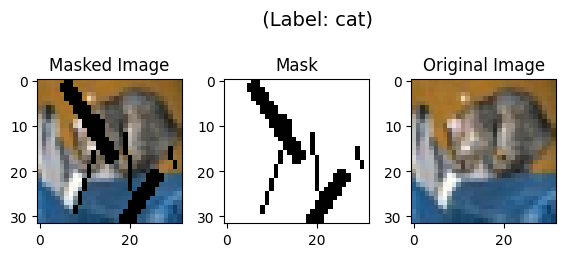

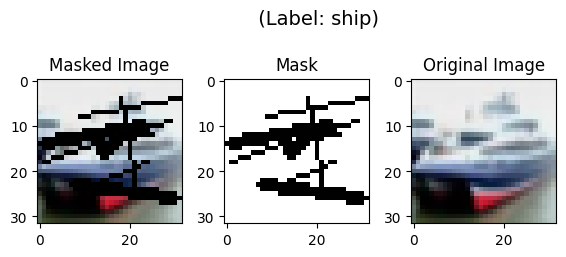

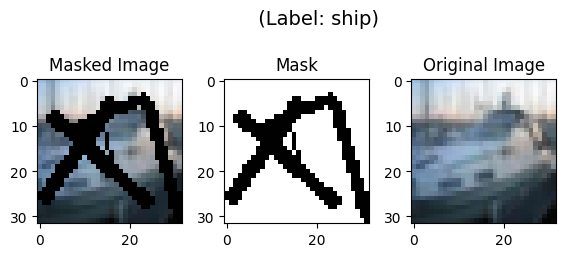

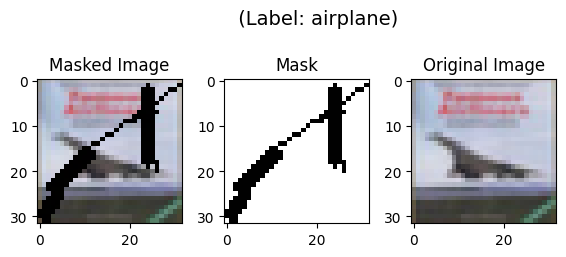

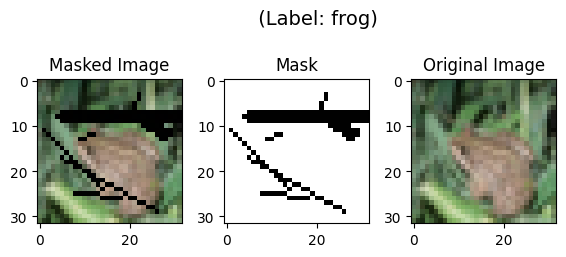

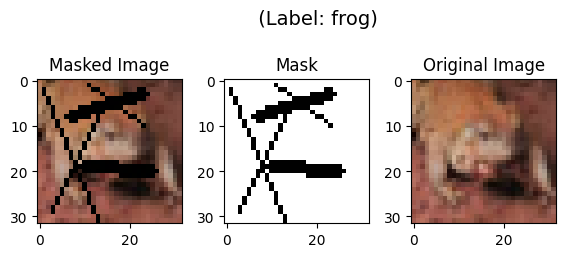

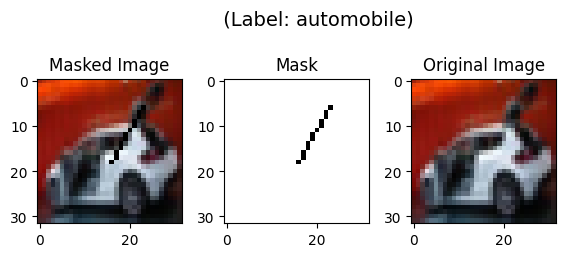

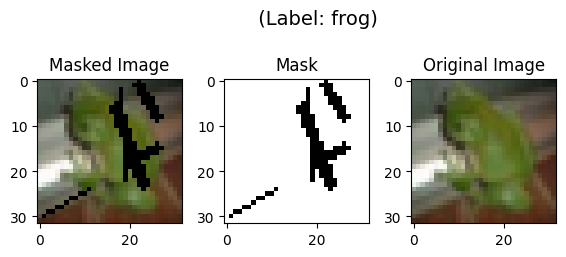

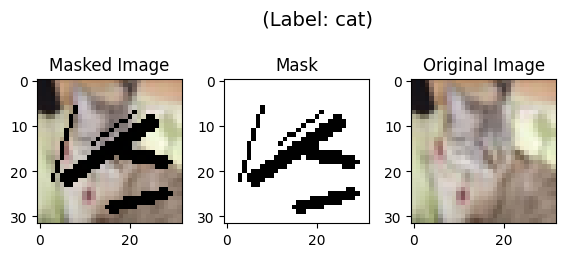

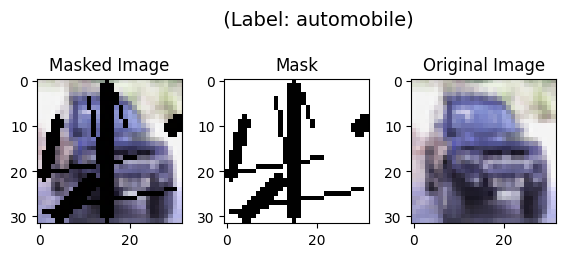

In [ ]:
# 2. Randomly pick one image per class and display original, masked and recosntructed versions
# Build index lists
class_indices = {i: [] for i in class_names}
for idx, label in enumerate(val_labels_list):
    class_indices[label].append(idx)
# Sample one per class
selected_indices = [(c, rand.choice(class_indices[c])) for c in class_names]
# print(selected_indices)
for i, (c, idx) in enumerate(selected_indices):
  # print(f"{i}) {c} ")
  masked_img, mask, orginal_img, label = Testset[i]
  show_imgs(masked_img, mask, orginal_img, label)

In [10]:
print("Train label distribution:")
print(Counter(train_labels_list))

print("Validation label distribution:")
print(Counter(val_labels_list))

Train label distribution:
Counter({'frog': 5000, 'truck': 5000, 'deer': 5000, 'automobile': 5000, 'bird': 5000, 'horse': 5000, 'ship': 5000, 'cat': 5000, 'dog': 5000, 'airplane': 5000})
Validation label distribution:
Counter({'cat': 1000, 'ship': 1000, 'airplane': 1000, 'frog': 1000, 'automobile': 1000, 'truck': 1000, 'dog': 1000, 'horse': 1000, 'deer': 1000, 'bird': 1000})


## Analysis of shallow U-net like architecture for Denoising Autoencoder

In [12]:
batch_size = 128
Trainloader = torch.utils.data.DataLoader(Trainset, batch_size = batch_size, shuffle = True)
Testloader = torch.utils.data.DataLoader(Testset, batch_size = batch_size, shuffle = False)

In [ ]:
class UNet_AutoEncoder(nn.Module):
    def __init__(
        self,
        middle_layer_maps_1 = 32,
        middle_layer_maps_2 = 64,
        final_layer_maps    = 128,
        latent_dim         = 350):
        super().__init__()
        # save for reference
        self.m1 = middle_layer_maps_1
        self.m2 = middle_layer_maps_2
        self.f  = final_layer_maps
        self.ld = latent_dim

        # ENCODER
        # 32*32 to 16*16 and then 16*16 to 16*16
        # in the following block, I have used convs with different kernel sizes to capture different levels of detail 
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, self.m1, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.m1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.m1, self.m1, kernel_size=5, padding=2),
            nn.BatchNorm2d(self.m1),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.pool1 = nn.MaxPool2d(2)
        # I have included also max-pooling layers since they can help remove black/corrupted pixels from the mask
        # by conserving only the highest value in a given 2 by 2 region

        # 16*16 to 8*8
        self.enc2 = nn.Sequential(
            nn.Conv2d(self.m1, self.m2, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.m2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.pool2 = nn.MaxPool2d(2)

        # 8*8 to 4*4
        self.enc3 = nn.Sequential(
            nn.Conv2d(self.m2, self.f, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(self.f),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # 4*4 to 2*2
        self.enc4 = nn.Sequential(
            nn.Conv2d(self.f, self.f, kernel_size=2, stride=2),
            nn.BatchNorm2d(self.f),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # bottleneck fully-connected
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(self.f * 2 * 2, self.ld)
        self.fc2 = nn.Linear(self.ld, self.f * 2 * 2)

        # DECODER
        # 2*2 to 4*4
        self.up1 = nn.ConvTranspose2d(
            self.f, self.f,
            kernel_size=2, stride=2
        )
        self.dec0 = nn.Sequential(
            nn.BatchNorm2d(self.f),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # 4*4 to 8*8
        self.up2 = nn.ConvTranspose2d(
            self.f * 2, self.m2,
            kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.dec1 = nn.Sequential(
            nn.BatchNorm2d(self.m2),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # 8*8 to 16*16
        self.up3 = nn.ConvTranspose2d(
            self.m2 * 2, self.m1,
            kernel_size=2, stride=2
        )
        self.dec2 = nn.Sequential(
            nn.BatchNorm2d(self.m1),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # 16*16 to 32*32
        self.up4 = nn.ConvTranspose2d(
            self.m1 * 2, self.m1,
            kernel_size=2, stride=2
        )
        self.dec3 = nn.Sequential(
            nn.BatchNorm2d(self.m1),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # extra convolution at full resolution
        self.conv_final_block = nn.Sequential(
            nn.Conv2d(self.m1, self.m1, kernel_size=5, padding=2),
            nn.BatchNorm2d(self.m1),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.final_conv = nn.Conv2d(self.m1, 3, kernel_size=3, padding=1)
        self.output_act = nn.Sigmoid()

    def forward(self, x: torch.Tensor):
        # ENCODER
        x1  = self.enc1(x)     
        x1p = self.pool1(x1)   

        x2  = self.enc2(x1p)   
        x2p = self.pool2(x2)   

        x3  = self.enc3(x2p)   
        x4  = self.enc4(x3)    

        # bottleneck
        lat   = self.fc1(self.flatten(x4))          
        x_lat = self.fc2(lat).view(-1, self.f, 2, 2) 

        # DECODER
        y = self.up1(x_lat)            # [B, f, 4, 4]
        y = self.dec0(y)
        y = torch.cat([y, x3], dim=1)  # [B, f*2, 4, 4]

        y = self.up2(y)                # [B, m2, 8, 8]
        y = self.dec1(y)
        y = torch.cat([y, x2p], dim=1) # [B, m2*2, 8, 8]

        y = self.up3(y)                # [B, m1,16,16]
        y = self.dec2(y)
        y = torch.cat([y, x1p], dim=1) # [B, m1*2,16,16]

        y = self.up4(y)                # [B, m1,32,32]
        y = self.dec3(y)

        y = self.conv_final_block(y)   # [B, m1,32,32]
        y = self.final_conv(y)         # [B,  3,32,32]
        return self.output_act(y)

In [ ]:
#Training with MSE loss
model = UNet_AutoEncoder()
model = model.to(device)
#DISPLAY MODEL
summary(model, input_size=(3, 32, 32))

#DEFINE LOSS and OPTIMIZER
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)
# for given btach size = 128, with learning rate 1e-3 optimizer convergence is fast,
# overshooting a little and then fluctuating around the minimum

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         LeakyReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]          25,632
       BatchNorm2d-5           [-1, 32, 32, 32]              64
         LeakyReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
       BatchNorm2d-9           [-1, 64, 16, 16]             128
        LeakyReLU-10           [-1, 64, 16, 16]               0
        MaxPool2d-11             [-1, 64, 8, 8]               0
           Conv2d-12            [-1, 128, 4, 4]          73,856
      BatchNorm2d-13            [-1, 128, 4, 4]             256
        LeakyReLU-14            [-1, 12

In [22]:
#store loss
training_loss = []

num_epochs = 30 #at least 20 for 1e-4 learning rate
for epoch in range(num_epochs):
  model.train()
  tot_loss = 0
  for corrupt_imgs, _ , true_imgs, _ in tqdm(Trainloader):
    true_imgs = true_imgs.to(device)
    corrupt_imgs = corrupt_imgs.to(device)

    # Forward pass
    outputs = model(corrupt_imgs)
    loss = criterion(outputs, true_imgs)

    # Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    tot_loss += loss.item()
  # Save model checkpoint every 10 epochs
  if (epoch + 1) % 10 == 0:
      torch.save(model.state_dict(), f'vae_cifar_10_epoch_{epoch+1}.pth')
  #save loss for later use
  training_loss.append(tot_loss/len(Trainloader))
  print(f"Epoch [{epoch+1}/{num_epochs}], MSE Loss = {(tot_loss/len(Trainloader)):.4f}")
  scheduler.step(tot_loss/len(Trainloader))

100%|██████████| 391/391 [01:52<00:00,  3.47it/s]


Epoch [1/30], MSE Loss = 0.0067


100%|██████████| 391/391 [01:50<00:00,  3.54it/s]


Epoch [2/30], MSE Loss = 0.0034


100%|██████████| 391/391 [01:49<00:00,  3.57it/s]


Epoch [3/30], MSE Loss = 0.0029


100%|██████████| 391/391 [01:50<00:00,  3.54it/s]


Epoch [4/30], MSE Loss = 0.0027


100%|██████████| 391/391 [01:50<00:00,  3.53it/s]


Epoch [5/30], MSE Loss = 0.0025


100%|██████████| 391/391 [01:50<00:00,  3.55it/s]


Epoch [6/30], MSE Loss = 0.0024


100%|██████████| 391/391 [01:51<00:00,  3.52it/s]


Epoch [7/30], MSE Loss = 0.0023


100%|██████████| 391/391 [01:50<00:00,  3.54it/s]


Epoch [8/30], MSE Loss = 0.0023


100%|██████████| 391/391 [01:47<00:00,  3.65it/s]


Epoch [9/30], MSE Loss = 0.0022


100%|██████████| 391/391 [01:51<00:00,  3.51it/s]


Epoch [10/30], MSE Loss = 0.0021


100%|██████████| 391/391 [01:51<00:00,  3.52it/s]


Epoch [11/30], MSE Loss = 0.0021


100%|██████████| 391/391 [01:51<00:00,  3.50it/s]


Epoch [12/30], MSE Loss = 0.0020


100%|██████████| 391/391 [01:53<00:00,  3.46it/s]


Epoch [13/30], MSE Loss = 0.0020


100%|██████████| 391/391 [01:53<00:00,  3.46it/s]


Epoch [14/30], MSE Loss = 0.0020


100%|██████████| 391/391 [01:54<00:00,  3.42it/s]


Epoch [15/30], MSE Loss = 0.0019


100%|██████████| 391/391 [01:52<00:00,  3.48it/s]


Epoch [16/30], MSE Loss = 0.0019


100%|██████████| 391/391 [01:51<00:00,  3.52it/s]


Epoch [17/30], MSE Loss = 0.0019


100%|██████████| 391/391 [01:53<00:00,  3.45it/s]


Epoch [18/30], MSE Loss = 0.0019


100%|██████████| 391/391 [01:51<00:00,  3.50it/s]


Epoch [19/30], MSE Loss = 0.0018


100%|██████████| 391/391 [01:53<00:00,  3.44it/s]


Epoch [20/30], MSE Loss = 0.0018


100%|██████████| 391/391 [01:51<00:00,  3.49it/s]


Epoch [21/30], MSE Loss = 0.0018


100%|██████████| 391/391 [01:48<00:00,  3.60it/s]


Epoch [22/30], MSE Loss = 0.0018


100%|██████████| 391/391 [01:48<00:00,  3.62it/s]


Epoch [23/30], MSE Loss = 0.0018


100%|██████████| 391/391 [01:52<00:00,  3.47it/s]


Epoch [24/30], MSE Loss = 0.0018


100%|██████████| 391/391 [01:53<00:00,  3.45it/s]


Epoch [25/30], MSE Loss = 0.0018


100%|██████████| 391/391 [01:53<00:00,  3.45it/s]


Epoch [26/30], MSE Loss = 0.0017


100%|██████████| 391/391 [01:53<00:00,  3.46it/s]


Epoch [27/30], MSE Loss = 0.0017


100%|██████████| 391/391 [01:51<00:00,  3.50it/s]


Epoch [28/30], MSE Loss = 0.0017


100%|██████████| 391/391 [01:49<00:00,  3.56it/s]


Epoch [29/30], MSE Loss = 0.0017


100%|██████████| 391/391 [01:52<00:00,  3.47it/s]

Epoch [30/30], MSE Loss = 0.0017


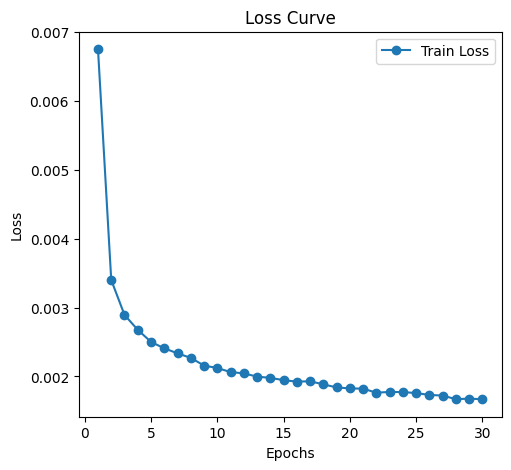

In [23]:
# Plot loss curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, (num_epochs+1)), training_loss, label="Train Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.show()

## MODEL EVALAUTION ON TEST SET

In [24]:
#model perfrmance on test set
model.eval()

mse_total = 0
psnr_total = 0
n = 0

with torch.no_grad():
    for img_mask, _, img_true, _ in Testloader:
        inputs = img_mask.to(device)
        outputs = model(inputs)
        # Accumulate metrics
        mse = F.mse_loss(outputs, img_true.to(device), reduction='mean')

        # PSNR calculation
        psnr = 10 * torch.log10(1.0 / mse)

        #update totals
        mse_total += mse.item()
        psnr_total += psnr.item()
        n+=1

# Final averages
print(f"Validation MSE:  {mse_total / n:.10f}")
print(f"Validation PSNR: {psnr_total / n:.5f} dB")

Validation MSE:  0.0017062069
Validation PSNR: 27.69396 dB


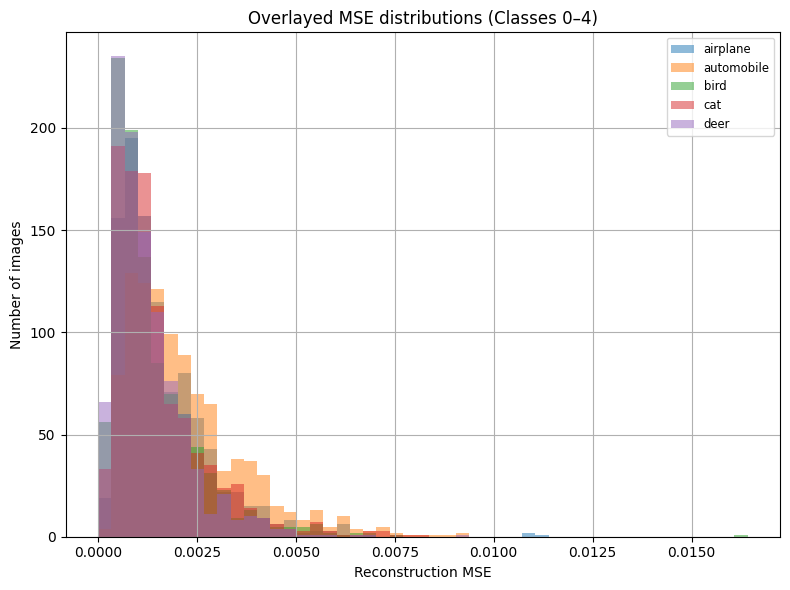

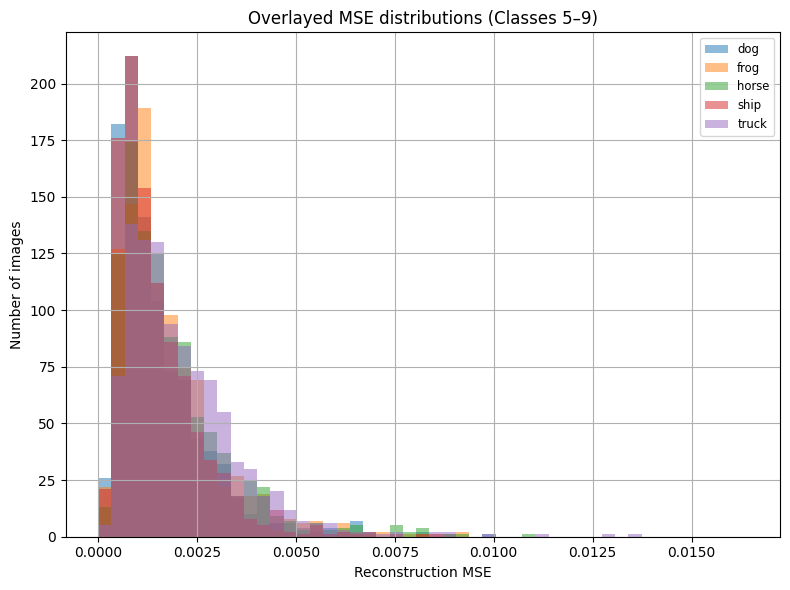

In [25]:
# Compute per-sample MSEs by class
model.eval()
mse_by_class = {i: [] for i in range(10)}

with torch.no_grad():
    for masked_imgs, _, og_img, labels in Testloader:
        corr_imgs = masked_imgs.to(device)
        og_img = og_img.to(device)
        recon = model(corr_imgs)
        batch_mse = F.mse_loss(recon, og_img, reduction='none') \
                       .view(masked_imgs.size(0), -1).mean(dim=1)
        for mse_val, lbl in zip(batch_mse.cpu().numpy(), labels.numpy()):
            mse_by_class[lbl].append(mse_val)

# Set bins globally for consistency across histograms
all_mse_values = [mse for lst in mse_by_class.values() for mse in lst]
bins = np.linspace(0, max(all_mse_values), 50)

# Plot 2 separate histograms of MSE for 5 classes each
for group in [(0, 5), (5, 10)]:
    plt.figure(figsize=(8, 6))
    for cls_idx in range(group[0], group[1]):
        plt.hist(mse_by_class[cls_idx], bins=bins, alpha=0.5, label=class_names[cls_idx])
    plt.xlabel("Reconstruction MSE")
    plt.ylabel("Number of images")
    plt.title(f"Overlayed MSE distributions (Classes {group[0]}–{group[1] - 1})")
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

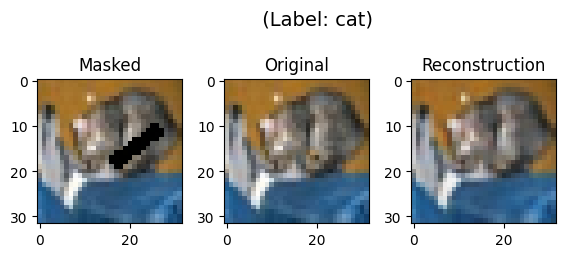

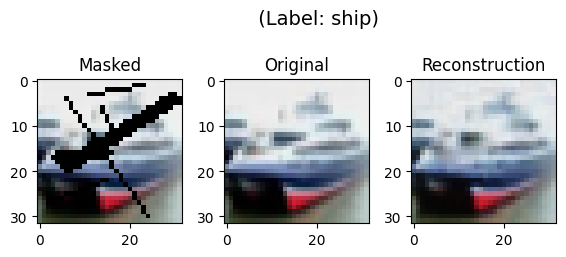

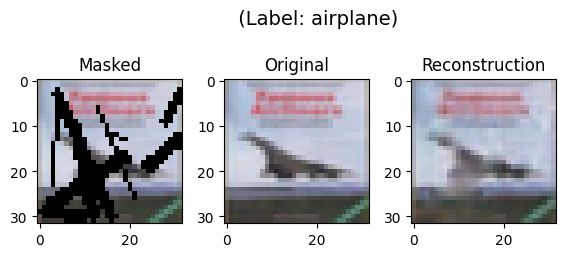

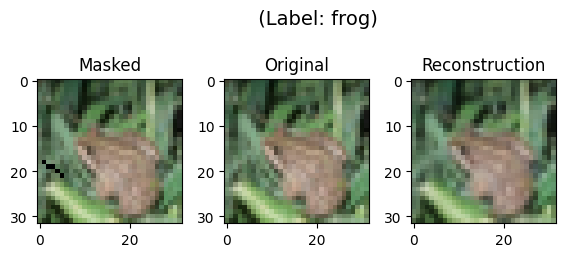

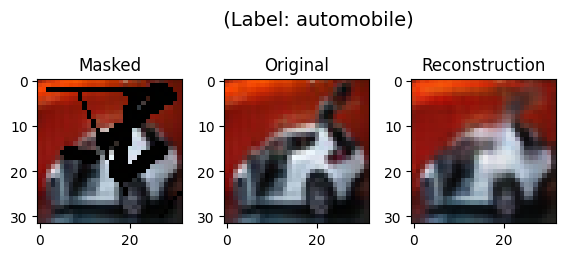

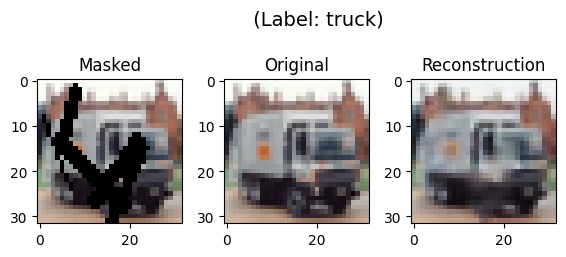

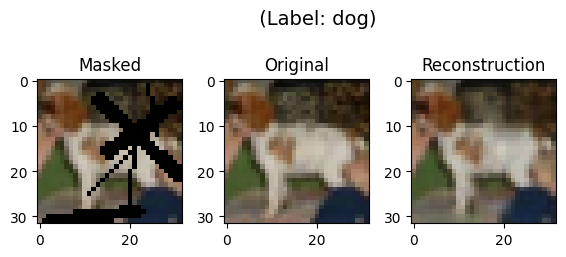

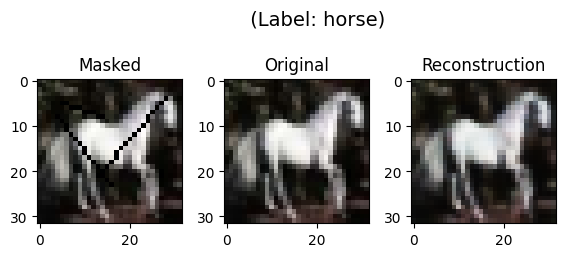

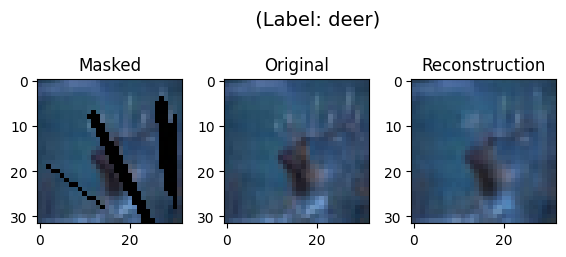

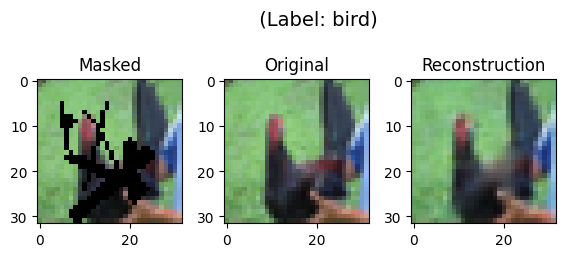

In [26]:
model.eval()
# Store one image per class
images_per_class = {}
images_mask_per_class = {}
reconstructions_per_class = {}

with torch.no_grad():
    for img_mask, _, img_true, label in Testloader:
        img_mask, img_true, label = img_mask.to(device), img_true.to(device), label.to(device)
        outputs = model(img_mask)

        for i in range(len(label)):
            class_id = label[i].item()
            if class_id not in images_per_class:
                images_per_class[class_id] = img_true[i].cpu()
                images_mask_per_class[class_id] = img_mask[i].cpu()
                reconstructions_per_class[class_id] = outputs[i].cpu()
            if len(images_per_class) == 10:
                break
        if len(images_per_class) == 10:
                break
for label in images_per_class.keys():
  show_imgs(images_mask_per_class[label], images_per_class[label], reconstructions_per_class[label], label,
            title1="Masked", title2="Original", title3="Reconstruction")